In [124]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf


In [125]:
def preprocessing_yf(symbol):
    global df
 #Import data
    df = yf.download(symbol).dropna()

 #Rename
    df.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df.index.name = "Date"

    #Remove adj close
    # del df["adj close"]

    return df

In [126]:
df = preprocessing_yf("AAPL")
df = df.rename_axis('Date').reset_index()
# df['Date'] = df['Date'].strftime('%Y-%m-%d')

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
10909,2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
10910,2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
10911,2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400
10912,2024-03-27,170.410004,173.600006,170.110001,173.309998,173.309998,60273300
10913,2024-03-28,171.750000,172.229996,170.509995,171.479996,171.479996,65672700


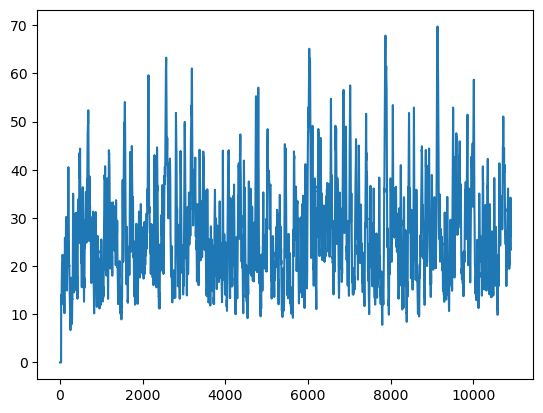

In [129]:
plt.plot(df['trend_adx'])
plt.plot(df['trend_adx'])

In [128]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Slow : 60+
# Fast : 15
# df['date'] = df['Date'].apply(lambda x: datetime.strptime(str(x),"%Y-%m-%d"))
df['dateInt'] = df['Date'].apply(lambda x: (x - datetime(1981,1,1)).days)

df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',

In [143]:
from pyti import catch_errors
import warnings
def chande_momentum_oscillator(close_data, period):
    """
    Chande Momentum Oscillator.

    Formula:
    cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    """
    catch_errors.check_for_period_error(close_data, period)

    close_data = np.array(close_data)

    moving_period_diffs = [[(close_data[idx+1-period:idx+1][i] -
                 close_data[idx+1-period:idx+1][i-1]) for i in range(1, len(close_data[idx+1-period:idx+1]))] for idx in range(0, len(close_data))]

    sum_up = []
    sum_down = []
    for period_diffs in moving_period_diffs:
        ups = [val if val > 0 else 0 for val in period_diffs]
        sum_up.append(sum(ups))
        downs = [abs(val) if val < 0 else 0 for val in period_diffs]
        sum_down.append(sum(downs))

    sum_up = np.array(sum_up)
    sum_down = np.array(sum_down)
    # numpy is able to handle dividing by zero and makes those calculations
    # nans which is what we want, so we safely suppress the RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    return cmo

# print(df['CMO'])
# plt.plot(df['Date'],df['CMO'])
# plt.plot(df['Date'],df['Close'])
# plt.show()
# fig, ax1 = plt.subplots(figsize=(8, 8))
# ax2 = ax1.twinx()

# ax1.plot(df['Date'],df['CMO'])
# ax2.plot(df['Date'],df['Close']);

In [145]:
# Feature Vector Calculations.

df['priceChange'] = df['Close']-df['Open']
df['classPriceChange'] = df['priceChange']>0
df['close_r20'] = df.Close.rolling(20).mean()
df['close_r200'] = df.Close.rolling(200).mean()
df['APO_momentum'] = df['close_r20']-df['close_r200']
df['BOP'] = ((df['Close']-df['Open'])/(df['High']-df['Low'])).rolling(14).mean()
df['CMO'] = chande_momentum_oscillator(df['Close'],period=20)
df['Momentum_10'] = df["Close"]-df["Close"].shift(10)


# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

C:\Users\mlilje01\AppData\Local\Temp\ipykernel_8848\1082825709.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Momentum_10'] = df["Close"]-df["Close"].shift(10)


In [156]:
# print([x for x in df['Momentum_10']])
# print([x for x in df['Close']])
# print(df['Close'].iloc[10]-df["Close"].iloc[0])

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.032366007566452026, 0.0351560041308403, 0.03962100297212601, 0.03850500285625458, 0.03180800378322601, 0.01785700023174286, 0.005580991506576538, -0.0027899891138076782, -0.002790004014968872, -0.017298996448516846, -0.024553000926971436, -0.020089000463485718, -0.012834995985031128, -0.015625, -0.003907009959220886, -0.0016739964485168457, 0.00725400447845459, 0.011717990040779114, 0.0039059966802597046, 0.0027899891138076782, 0.006696000695228577, 0.0016739964485168457, -0.006138011813163757, -0.012277007102966309, -0.027900993824005127, -0.01897299289703369, -0.017298996448516846, -0.01897299289703369, -0.01785700023174286, -0.02232099324464798, -0.021205000579357147, -0.020646996796131134, -0.016741998493671417, -0.012276992201805115, -0.0022330060601234436, -0.0016740038990974426, -0.013393007218837738, -0.0195310041308403, -0.018414996564388275, -0.015625, -0.008928999304771423, -0.003349006175994873, 0.0016750022768974304, 0.0

In [ ]:
df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','Date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        df[list(df.columns[97:])].shift(1)
    ],
    axis=1)
df2 = df2[1:].reset_index(drop=True)
df2.head()
print(df2.iloc[:,1:5])
# print(df2[1:5])
# df3 = df2.iloc[:, ::-1]
# print(df3)

In [ ]:
all_x = df2[df2.columns[3:]].values
all_y = df2['classPriceChange'].values
#df_input.head()

# Train on the range (01/01/2002) - (12/31/2018), keep (2000-2001) and (2019-2020)
train_test_mask = (df2['Date'] <= datetime(2019,12,30))&(df2['Date'] >= datetime(2005,1,1))

train_x = all_x[train_test_mask]
train_y = all_y[train_test_mask]

test_x = all_x[~train_test_mask]
test_y = all_y[~train_test_mask]
# print(train_test_mask)

In [ ]:
print(df2.columns)

In [ ]:
print(all_x.shape)
print(all_y.shape)

In [ ]:
lda = LinearDiscriminantAnalysis()
X_train_new = lda.fit_transform(train_x,train_y)
# X_test = lda.transform(X_test)
# print(X_train_new)
print(train_x[1,:]==X_train_new[1])

In [ ]:
# train_x[:,train_x[0,:] == X_train_new[0]]

In [ ]:
#CORRELATION HEATMAP

# correlation_matrix = df3.corr(numeric_only = True)
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title("Correlation Heatmap")
# plt.show()

In [ ]:
# # Visualize the distribution of each feature using histograms.
# plt.figure(figsize=(12, 6))
# for i, feature in enumerate(df.columns):
#     plt.subplot(2, 2, i + 1)
#     sns.histplot(data=df3, x=feature, hue='classPricechange', kde=True)
#     plt.title(f'{feature} Distribution')

# plt.tight_layout()
# plt.show()

In [ ]:
# # Create a pair plot to visualize relationships between different features and corresponding binary outcomes.
# ax = sns.pairplot(df3, hue='classPricechange', markers=["o", "s"])
# plt.suptitle("Pair Plot of technical indicators Dataset")
# sns.move_legend(
#     ax, "lower center",
#     bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
# plt.tight_layout()
# plt.show()

In [ ]:
myPipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB())])

parameter_grid = {
    # 'pca__n_components':[10,20,40,80],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x,train_y)
print(clf.classes_)

In [ ]:
param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

test_yhat = clf.best_estimator_.predict(test_x)

print("Best Parameter Selected:\t:",clf.best_params_)

threshold = 0.5 #THRESHOLDING VALUE TO CHANGE WHAT THRESHOLD REQUIRES A BUY CALL (ANYTHING ABOVE THIS THRESHOLD PREDICTS UPWARD PRICE MOVEMENT)
test_yhat = (clf.best_estimator_.predict_proba(test_x)[:, 1] > threshold).astype('float')

print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat))

In [ ]:
# # pd.set_option("max_columns", None) # show all cols
# pd.options.display.max_colwidth = 100
# pd.set_option('max_colwidth', None) # show full width of showing cols
# pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
# pd.options.display.max_seq_items = 200000
# pd.options.display.max_rows = 400000
# print(str(test_yhat))
# print(clf.best_estimator_.predict_proba(test_x))
# print((sum(clf.best_estimator_.predict_proba(test_x)[:, 1] > 0.6).astype('float')))
# # print(clf.best_estimator_.predict(test_x)[20:30])

In [ ]:
plt.hist(clf.best_estimator_.predict_proba(test_x)[:, 1],bins = 20)


In [ ]:

backtest_mask = (df2['Date'] >= datetime(2020,1,3))  #DATES TO USE BACKTEST TO DETERMINE PROFITABILITY
backtest_x = all_x[backtest_mask]
backtest_y = (clf.best_estimator_.predict_proba(backtest_x)[:, 1] > threshold).astype('float')
position = backtest_y*1
# print(position.shape)
position[position==0]=-1
# print(position)
index_values = df['Date'].loc[df['Date']>=datetime(2020,1,1)]
# print(index_values.shape)
dfpos=pd.DataFrame(position[1:],index=index_values)
print(dfpos.shape)
# print(df2['Date'].loc[backtest_mask])

# print(backtest_x.shape)
pct = df['Close'].loc[df['Date']>=datetime(2020,1,1)].pct_change(1).dropna() ##takes the percentage change of the close between each row, between every day since the input is 1, if input was 2, it would be the percent change of the stock over every 2 days
dfpct = pd.DataFrame(pct.values, index=index_values)
returnoninvestment = dfpct* dfpos.shift(1)  #calculate the return of our strategy (shift(1) tells program to use the previous position in the calculation because that tells us how much percent change that position has gained or lost from then to the present)
dfreturn = pd.DataFrame(returnoninvestment, index=index_values).dropna()
# print(dfreturn)
# dfreturn = dfreturn.rename(columns={'0':'return'})
dfreturn.name='return'
print(dfreturn)
# print(test_yhat)
# print(df2.columns)
dummy = df['Close'].loc[df['Date']>=datetime(2020,1,1)]
print(df['Date'].loc[df['Date']>=datetime(2020,1,1)])
print(dummy)
print(dummy.iloc[1])
print(pct.iloc[1])

In [ ]:
print([x for x in clf.best_estimator_.predict_proba(backtest_x)[:, 1]])

In [ ]:
from sklearn import metrics


probs = clf.predict_proba(test_x)
prob_prd = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(test_y, prob_prd)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
all_x.shape

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X = np.arange(6).reshape(3, 2)

In [ ]:
def drawdown_function(series):
    cum = series.dropna().cumsum() + 1
    running_max = np.maximum.accumulate(cum)   #this function accumulates the max of the cumulative sum, for example (1,3,5,3,1) becomes (1,3,5,5,5) this will continue with 5 until a higher value comes along

    drawdown = cum/running_max -1
    return drawdown

In [ ]:
#### Backtest Function ####
def BackTest(series, annualized_scalar=252):   #default annualized_scalar data to 252 for daily sortino and alpha. if annualized_scalar = 12, this would correspond to monthly data.
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1) # import percent change of daily close every day

    sp500.name = "SP500" #Change the name
    series.name='return'
    val = pd.concat((series, sp500), axis=1).dropna() # put together the return of our data and the return of the sp500 concatenated along columns
  
    drawdown = drawdown_function(series) *100 # compute the drawdown (the risk of strategy)

    max_drawdown= - np.min(drawdown) #compute max drawdown

    fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6)) #initialize two subplots, 'cum' and 'dra'
    fig.suptitle("BackTesting", size=20)  #add subtitle

    # print(series.cumsum()*100)
    # print(val["SP500"].cumsum()*100)
    cum.plot(series.cumsum()*100, color = "#B85A0F") # plot cumulative sum of returns for data
    cum.plot(val["SP500"].cumsum()*100)#, color = "#B85A0F") #plot cumulative sum of returns for index (index meant to represent the market)
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return", size= 13)
    cum.set_ylabel("Cumulative Return %", size = 11)

    # print(drawdown)
    # print(drawdown.index)
    # print(drawdown.shape)
    dra.fill_between(drawdown.index, 0, drawdown, color = "#C73954", alpha=0.65) #Adds plot of the drawdown, with all the space between y=0 and y=drawdown being filled (what fill_between does) over the domain of the time the data takes place over fill_between(x, y1, y2=0)
    dra.set_title("Drawdown", size = 13)
    dra.set_ylabel("Drawdown in %", size=11)
    plt.show()
    # print(val)
    sortino = np.sqrt(annualized_scalar) * series.mean()/series.loc[series<0].std() #compute the sortino 
    beta = np.cov(val[["return", "SP500"]].values, rowvar=False)[0][1] / np.var(val["SP500"].values) #compute the beta
    alpha = (annualized_scalar) * series.mean() - (annualized_scalar)*beta*series.mean() #compute the alpha

    print(f"Sortino: {np.round(sortino,3)}")
    print(f"Beta:{np.round(beta,3)}")
    print(f"Alpha:{np.round(alpha*100,3)} %")
    print(f"Max Drawdown:{np.round(max_drawdown,3)} %")

    ######################
BackTest(dfreturn.squeeze())